In [73]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

In [74]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

In [75]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

100 100


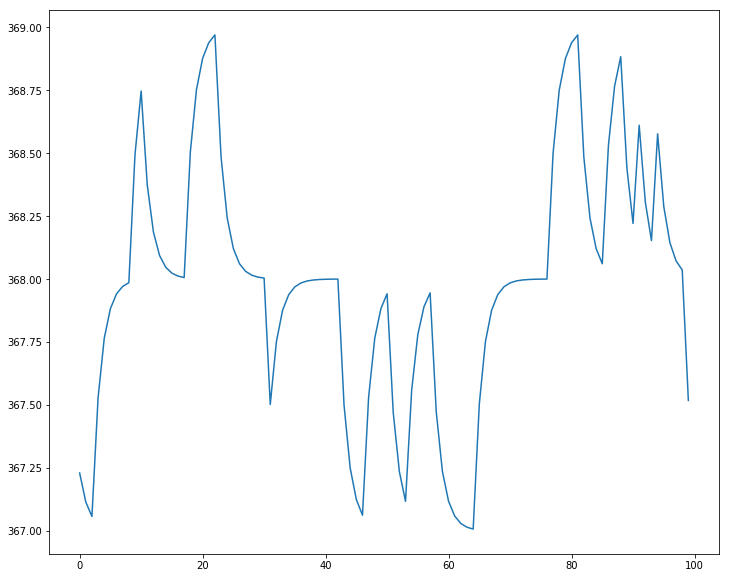

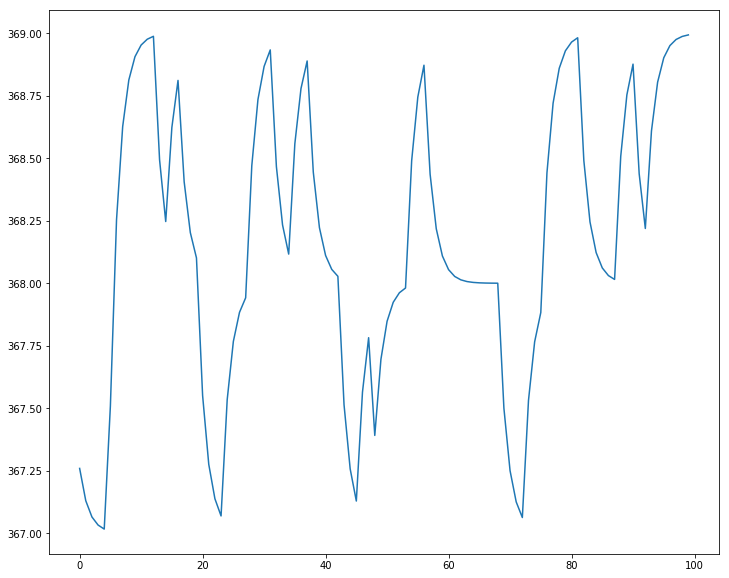

In [76]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 4000
border = 4100
num = 4200
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

Результат теста:
ADF Test Statistic : -5.877042095927208
p-value : 3.1417076161622136e-07
#Lags Used : 4
Number of Observations Used : 94
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


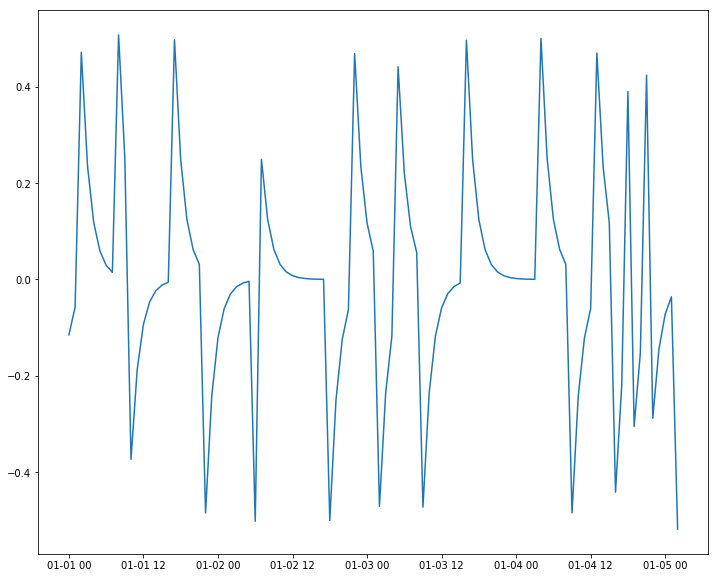

In [145]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1_diff = df1.diff().dropna()
while(df_test(df1_diff['flow1']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1['flow1']), freq='h')
df1_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1_diff['flow1']), freq='h')
plt.plot(df1_diff['flow1'])

Результат теста:
ADF Test Statistic : -4.041020178812329
p-value : 0.001210311046683184
#Lags Used : 1
Number of Observations Used : 98
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


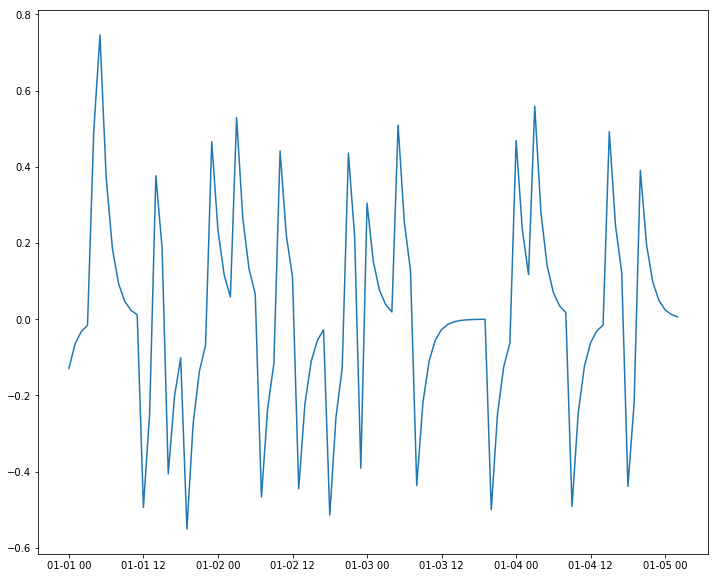

In [144]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2_diff = df2.diff().dropna()
while((df_test(df2['flow1']) != True) and (i in range (1, 10))):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2_diff['flow1'])

In [146]:
period = 24
fit1 = ExponentialSmoothing(
    df1_diff['flow1'],
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit2 = ExponentialSmoothing(
    df1_diff['flow1'],
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit3 = ExponentialSmoothing(
    df1_diff['flow1'],
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()
fit4 = ExponentialSmoothing(
    df1_diff['flow1'],
    seasonal_periods = period,
    trend="add",
    seasonal="add",
).fit()

In [147]:
forecast1 = fit1.forecast(100)
forecast2 = fit2.forecast(100)
forecast3 = fit3.forecast(100)
forecast4 = fit4.forecast(100)

In [148]:
predictions1 = pd.Series(forecast1.values, index=df2["flow1"].index)
predictions2 = pd.Series(forecast2.values, index=df2["flow1"].index)
predictions3 = pd.Series(forecast3.values, index=df2["flow1"].index)
predictions4 = pd.Series(forecast4.values, index=df2["flow1"].index)

In [149]:
difference = np.mean(predictions4 - df2_diff['flow1'])
forecast_mse1 = np.sqrt(((predictions4 - df2_diff['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.35028967163706215 -0.18360772725200025


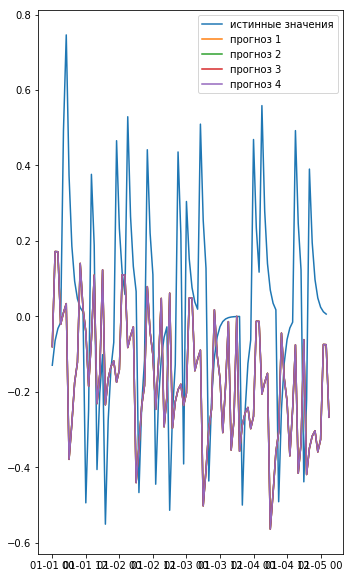

In [152]:
  
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df2_diff['flow1'], label = "истинные значения")
figure2 = pylab.plot(predictions1, label = "прогноз 1")
figure3 = pylab.plot(predictions2, label = "прогноз 2")
figure4 = pylab.plot(predictions3, label = "прогноз 3")
figure5 = pylab.plot(predictions4, label = "прогноз 4")
pylab.legend()